In [1]:
import os
import random
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image
from torch import nn, List, Tensor
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from torch.autograd import Variable
from torch import distributions as dist

In [2]:
#For one dataset
class BMPLoader(Dataset):
    def __init__(self, base_directory):
        self.base_directory = base_directory
        self.file_names = [os.path.join(base_directory, f) for f in os.listdir(base_directory) if f.endswith('.bmp')]
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Converts to [0, 1] range
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1] range
        ])
    
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, idx):
        img = Image.open(self.file_names[idx])
        img = img.convert('L')  # Convert to grayscale
        return self.transform(img)

In [3]:
# Data for ACL
dataset = BMPLoader('../data/terrain_bitmaps/Automatic-CL/TrainSet-train')
# # Data for MCL
# dataset = BMPLoader('../data/terrain_bitmaps/Manual-CL/TrainSet')
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Print the number of images in the dataset
print(f"Number of images in the dataset: {len(dataset)}")

# #Test for subset
# subset_indices = random.sample(range(len(dataset)), 1000)
# subset_dataset = Subset(dataset, subset_indices)
# dataloader = DataLoader(subset_dataset, batch_size=64, shuffle=True)

Number of images in the dataset: 50000


In [4]:
from torch import nn
from abc import abstractmethod
from typing import Callable, List, Any, Optional, Sequence, Type

class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [5]:
class SWAE(BaseVAE):

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 reg_weight: int = 100,
                 wasserstein_deg: float= 2.,
                 num_projections: int = 200,
                 projection_dist: str = 'normal',
                    **kwargs) -> None:
        super(SWAE, self).__init__()

        self.latent_dim = latent_dim
        self.reg_weight = reg_weight
        self.p = wasserstein_deg
        self.num_projections = num_projections
        self.proj_dist = projection_dist

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_z = nn.Linear(hidden_dims[-1]*4, latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> Tensor:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        z = self.fc_z(result)
        return z

    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        z = self.encode(input)
        return  [self.decode(z), input, z]

    def loss_function(self, recons, input, z) -> dict:
        batch_size = input.size(0)
        bias_corr = batch_size *  (batch_size - 1)
        reg_weight = self.reg_weight / bias_corr

        recons_loss_l2 = F.mse_loss(recons, input)
        recons_loss_l1 = F.l1_loss(recons, input)

        swd_loss = self.compute_swd(z, self.p, reg_weight)

        loss = recons_loss_l2 + recons_loss_l1 + swd_loss
        return loss

    def get_random_projections(self, latent_dim: int, num_samples: int) -> Tensor:
        """
        Returns random samples from latent distribution's (Gaussian)
        unit sphere for projecting the encoded samples and the
        distribution samples.

        :param latent_dim: (Int) Dimensionality of the latent space (D)
        :param num_samples: (Int) Number of samples required (S)
        :return: Random projections from the latent unit sphere
        """
        if self.proj_dist == 'normal':
            rand_samples = torch.randn(num_samples, latent_dim)
        elif self.proj_dist == 'cauchy':
            rand_samples = dist.Cauchy(torch.tensor([0.0]),
                                       torch.tensor([1.0])).sample((num_samples, latent_dim)).squeeze()
        else:
            raise ValueError('Unknown projection distribution.')

        rand_proj = rand_samples / rand_samples.norm(dim=1).view(-1,1)
        return rand_proj # [S x D]


    def compute_swd(self,
                    z: Tensor,
                    p: float,
                    reg_weight: float) -> Tensor:
        """
        Computes the Sliced Wasserstein Distance (SWD) - which consists of
        randomly projecting the encoded and prior vectors and computing
        their Wasserstein distance along those projections.

        :param z: Latent samples # [N  x D]
        :param p: Value for the p^th Wasserstein distance
        :param reg_weight:
        :return:
        """
        prior_z = torch.randn_like(z) # [N x D]
        device = z.device

        proj_matrix = self.get_random_projections(self.latent_dim,
                                                  num_samples=self.num_projections).transpose(0,1).to(device)

        latent_projections = z.matmul(proj_matrix) # [N x S]
        prior_projections = prior_z.matmul(proj_matrix) # [N x S]

        # The Wasserstein distance is computed by sorting the two projections
        # across the batches and computing their element-wise l2 distance
        w_dist = torch.sort(latent_projections.t(), dim=1)[0] - \
                 torch.sort(prior_projections.t(), dim=1)[0]
        w_dist = w_dist.pow(p)
        return reg_weight * w_dist.mean()
    
    def freeze_encoder(self):
        for param in list(self.encoder.parameters()) + list(self.fc_z.parameters()):
            param.requires_grad = False

In [11]:
# Test which dimension is better
latent_dims = [8, 16, 32, 64, 128, 256, 512, 1024]  # Example latent dimensions to test
num_epochs = 100
learning_rate = 5e-3
loss_values_per_dim = {}

for latent_dim in latent_dims:
    model = SWAE(in_channels=1, latent_dim=latent_dim)
    
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    loss_values = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        num_batches = 0
        for batch_idx, img in enumerate(dataloader):
            img = img.to(device)
            optimizer.zero_grad()
            recon_batch, input, z = model(img)
            loss = model.loss_function(recon_batch, input, z)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            num_batches += 1
        
        average_loss = train_loss / num_batches
        loss_values.append(average_loss)
        print(f'Latent Dim: {latent_dim}, Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}')

    loss_values_per_dim[latent_dim] = loss_values

True
Latent Dim: 8, Epoch [1/100], Average Loss: 0.2868
Latent Dim: 8, Epoch [2/100], Average Loss: 0.1576
Latent Dim: 8, Epoch [3/100], Average Loss: 0.1201
Latent Dim: 8, Epoch [4/100], Average Loss: 0.1058
Latent Dim: 8, Epoch [5/100], Average Loss: 0.0806
Latent Dim: 8, Epoch [6/100], Average Loss: 0.0689
Latent Dim: 8, Epoch [7/100], Average Loss: 0.0724
Latent Dim: 8, Epoch [8/100], Average Loss: 0.0644
Latent Dim: 8, Epoch [9/100], Average Loss: 0.0596
Latent Dim: 8, Epoch [10/100], Average Loss: 0.0620
Latent Dim: 8, Epoch [11/100], Average Loss: 0.0611
Latent Dim: 8, Epoch [12/100], Average Loss: 0.0562
Latent Dim: 8, Epoch [13/100], Average Loss: 0.0592
Latent Dim: 8, Epoch [14/100], Average Loss: 0.0522
Latent Dim: 8, Epoch [15/100], Average Loss: 0.0550
Latent Dim: 8, Epoch [16/100], Average Loss: 0.0517
Latent Dim: 8, Epoch [17/100], Average Loss: 0.0513
Latent Dim: 8, Epoch [18/100], Average Loss: 0.0523
Latent Dim: 8, Epoch [19/100], Average Loss: 0.0498
Latent Dim: 8, E

In [ ]:
# # Plotting the results
# for latent_dim, losses in loss_values_per_dim.items():
#     plt.plot(losses, label=f'Latent Dim: {latent_dim}')
# plt.xlabel('Epoch')
# plt.ylabel('Average Loss')
# plt.legend()
# plt.show()

In [12]:
mean_losses_per_dim = {latent_dim: np.mean(losses) for latent_dim, losses in loss_values_per_dim.items()}
print(mean_losses_per_dim)
min_dim, min_loss = min(mean_losses_per_dim.items(), key=lambda x: x[1])
print(min_dim, min_loss)

{8: 0.052836872797925025, 16: 0.05490089268423617, 32: 0.05352506820578128, 64: 0.05629359364509583, 128: 0.05746297722216696, 256: 0.05928002635482699, 512: 0.05831540362909436, 1024: 0.06493295717984437}
8 0.052836872797925025


In [6]:
model = SWAE(in_channels=1, latent_dim=64)

print(torch.cuda.is_available())
if torch.cuda.is_available():
    model.cuda()

True


In [7]:
# When not training, comment the following line
num_epochs = 500
learning_rate = 5e-3

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_values = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    num_batches = 0
    for batch_idx, img in enumerate(dataloader):
        img = img.to(device)
        optimizer.zero_grad()
        recon_batch, input, z = model(img)
        loss = model.loss_function(recon_batch, input, z) 
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        num_batches += 1
    
    average_loss = train_loss / num_batches
    loss_values.append(average_loss)  # Append the average loss over batches
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}')

Epoch [1/500], Average Loss: 0.0701
Epoch [2/500], Average Loss: 0.0455
Epoch [3/500], Average Loss: 0.0387
Epoch [4/500], Average Loss: 0.0425
Epoch [5/500], Average Loss: 0.0333
Epoch [6/500], Average Loss: 0.0319
Epoch [7/500], Average Loss: 0.0305
Epoch [8/500], Average Loss: 0.0300
Epoch [9/500], Average Loss: 0.0294
Epoch [10/500], Average Loss: 0.0285
Epoch [11/500], Average Loss: 0.0280
Epoch [12/500], Average Loss: 0.0279
Epoch [13/500], Average Loss: 0.0273
Epoch [14/500], Average Loss: 0.0270
Epoch [15/500], Average Loss: 0.0263
Epoch [16/500], Average Loss: 0.0259
Epoch [17/500], Average Loss: 0.0258
Epoch [18/500], Average Loss: 0.0257
Epoch [19/500], Average Loss: 0.0250
Epoch [20/500], Average Loss: 0.0250
Epoch [21/500], Average Loss: 0.0248
Epoch [22/500], Average Loss: 0.0245
Epoch [23/500], Average Loss: 0.0244
Epoch [24/500], Average Loss: 0.0243
Epoch [25/500], Average Loss: 0.0242
Epoch [26/500], Average Loss: 0.0238
Epoch [27/500], Average Loss: 0.0239
Epoch [28/

In [8]:
# When not training, comment the following line
model.freeze_encoder()
print("Encoder layers have been frozen.")
# # Save for ACL
# torch.save(model.state_dict(), './SWAE_ACL64.pth')
# Save for MCL
torch.save(model.state_dict(), './SWAE_64.pth')

Encoder layers have been frozen.


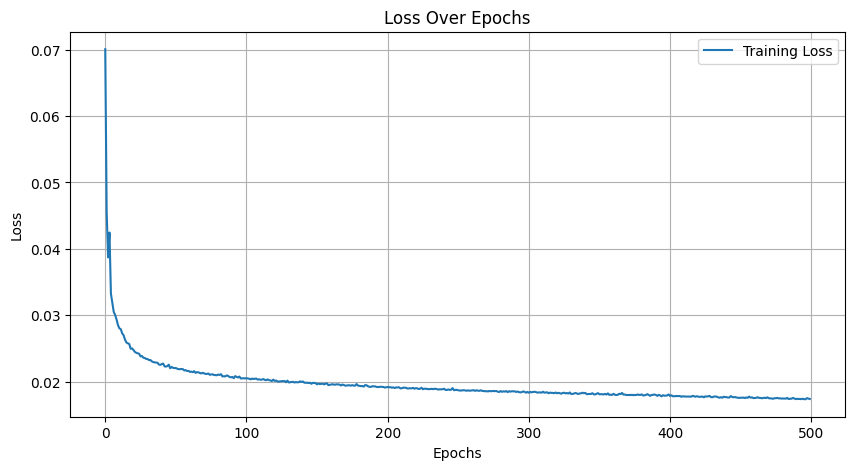

In [9]:
# When not training, comment the following line
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# # Data for ACL
# Trainset = BMPLoader('../data/terrain_bitmaps/Automatic-CL/TrainSet-train')
# Testset = BMPLoader('../data/terrain_bitmaps/Automatic-CL/TrainSet-test')

# Data for MCL
Trainset = BMPLoader('../data/terrain_bitmaps/Manual-CL/TrainSet')
Testset = BMPLoader('../data/terrain_bitmaps/Manual-CL/TestSet')

Visualizing reconstructions of training images...


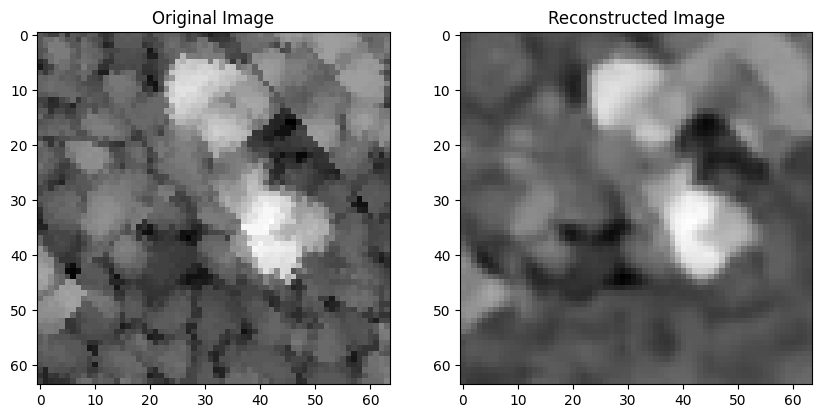

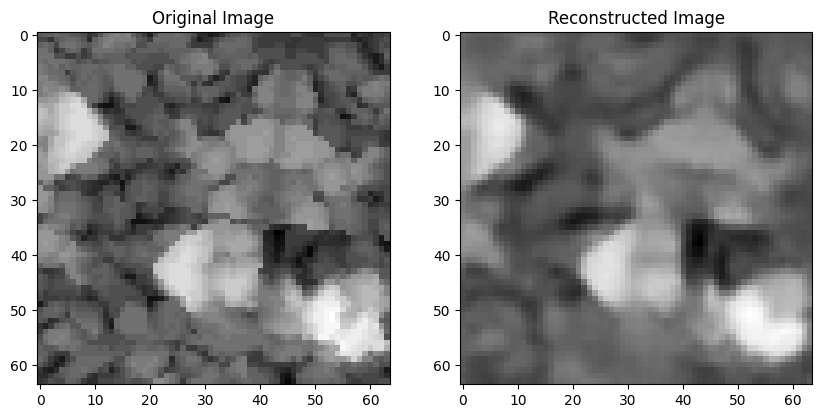

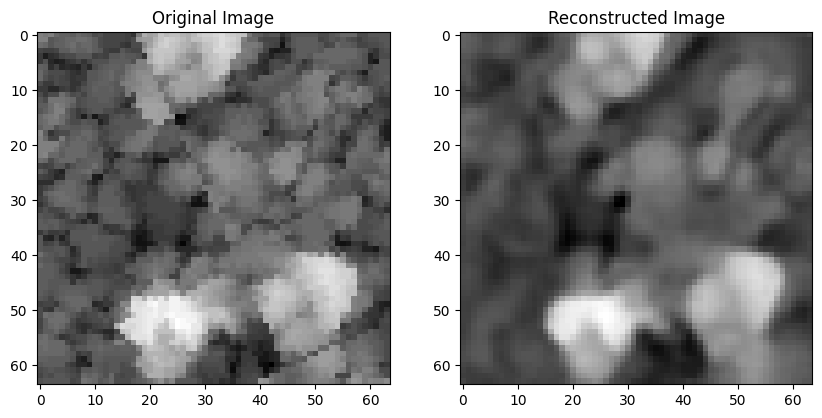

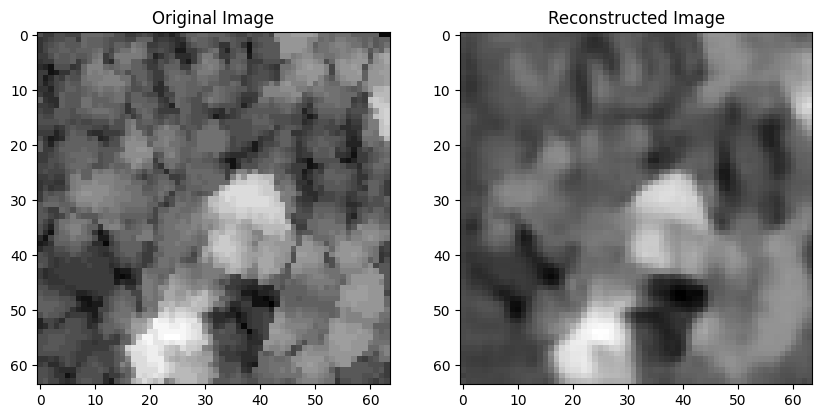

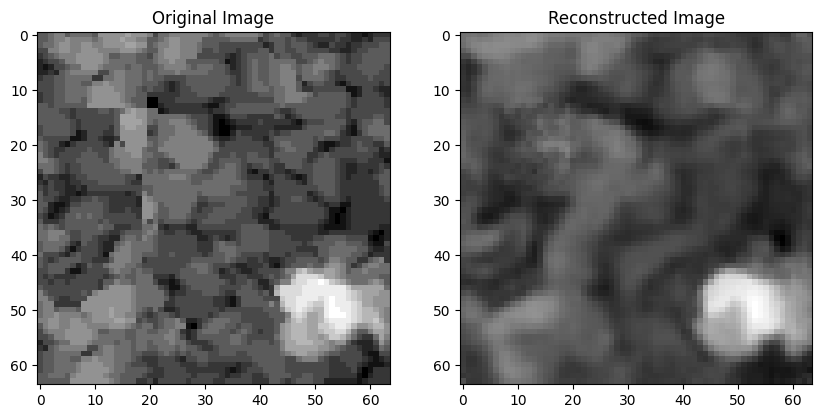

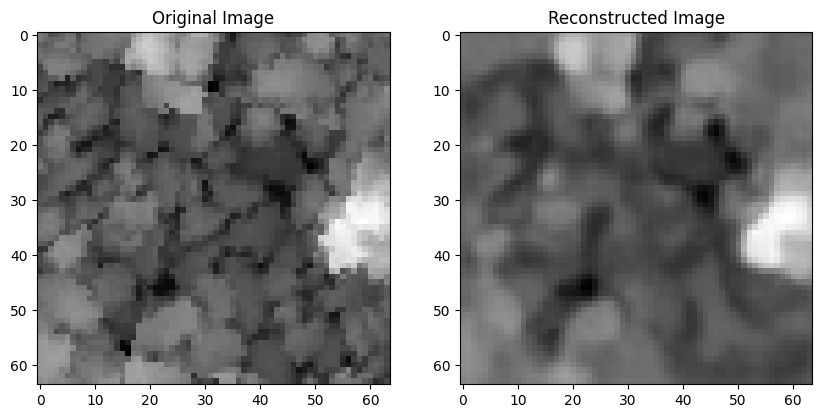

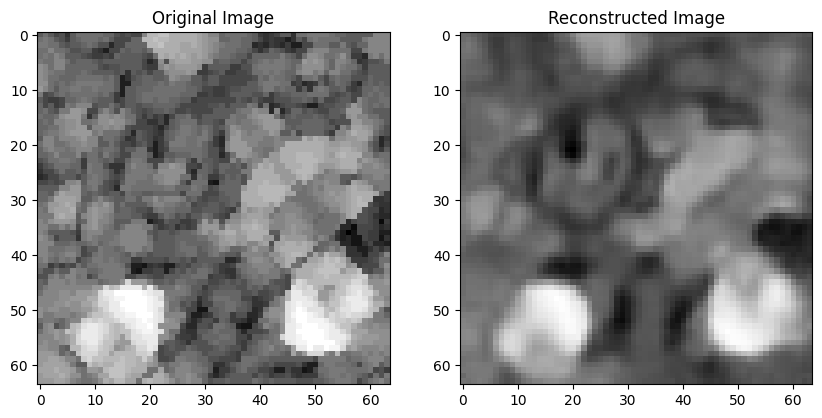

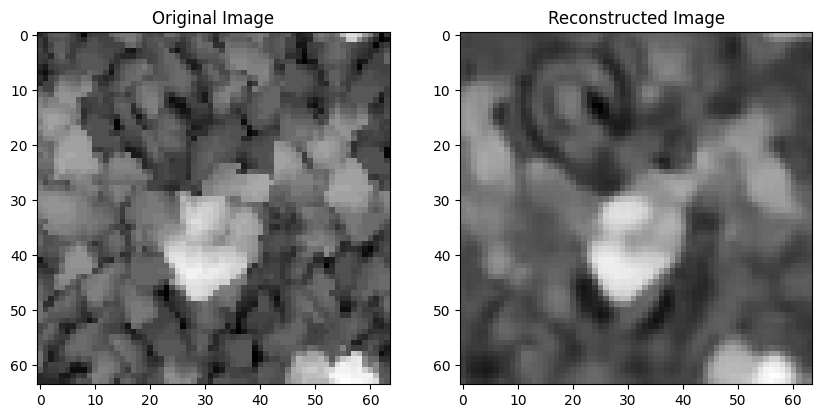

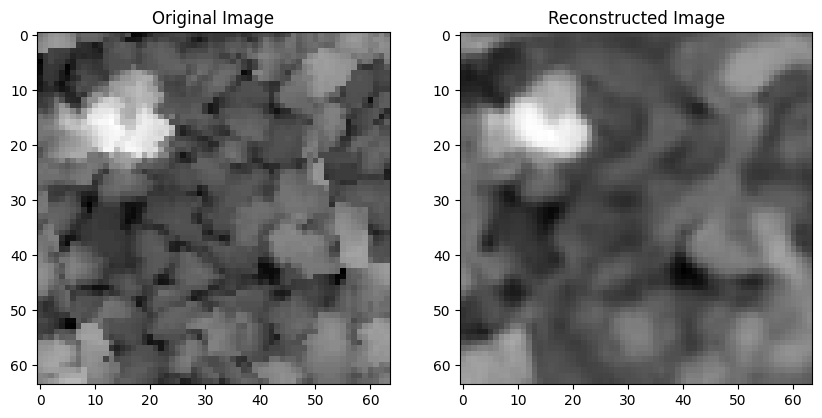

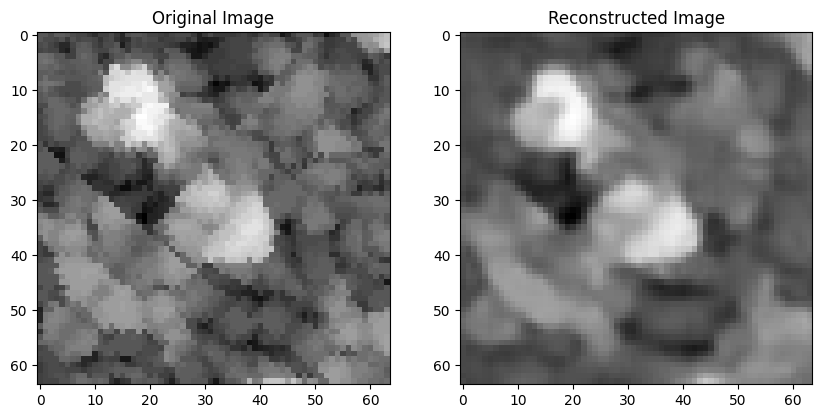

In [8]:
# View the reconstructions of training images
import random
import matplotlib.pyplot as plt

# Function to convert tensor to image for visualization
def to_img(x):
    x = x.clamp(-1, 1) # Clamp values to [-1, 1]
    x = x.view(-1, 64, 64)
    return x

# Function to display original and reconstructed images
def display_images(original, reconstructed):
    original_img = to_img(original.cpu())
    reconstructed_img = to_img(reconstructed.cpu())
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img[0].numpy(), cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_img[0].numpy(), cmap='gray')
    plt.title('Reconstructed Image')
    plt.show()

# Main loop to process and display images from the train set
def visualize_reconstructions(model, trainset, num_images=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load('./SWAE_64.pth', map_location=device))
    model.eval()
    model.to(device)
    
    # Randomly pick indices for images
    indices = random.sample(range(len(trainset)), num_images)
    
    # Loop through the randomly selected indices
    for idx in indices:
        img = trainset[idx].unsqueeze(0).to(device)
        
        # Get reconstruction
        with torch.no_grad():
            reconstructed_image, input, latentVector = model(img)
        
        # Display images
        display_images(img, reconstructed_image)

# Assuming 'Trainset' is your train dataset
print("Visualizing reconstructions of training images...")
visualize_reconstructions(model, Trainset)

Visualizing reconstructions of test images...


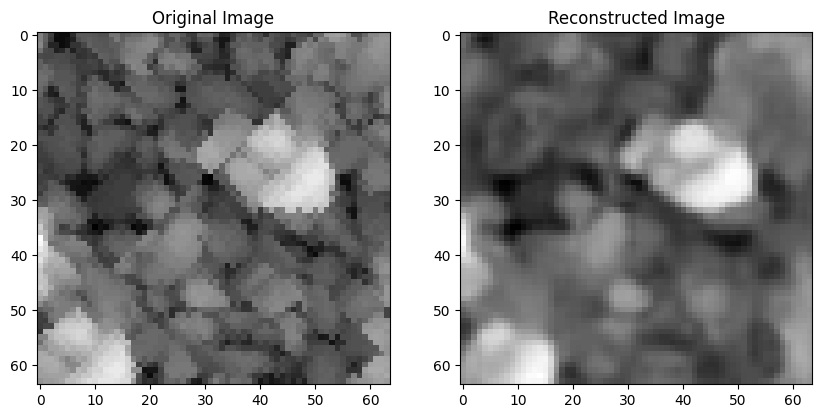

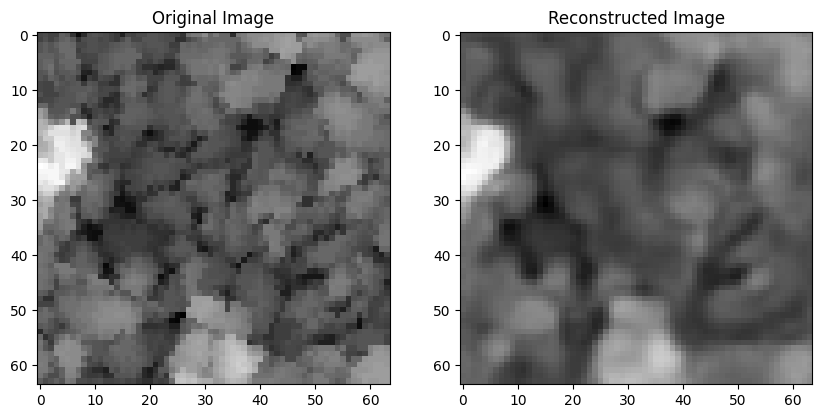

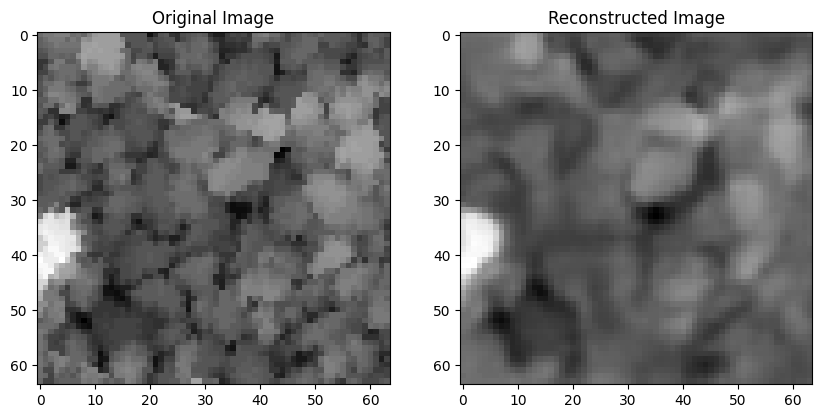

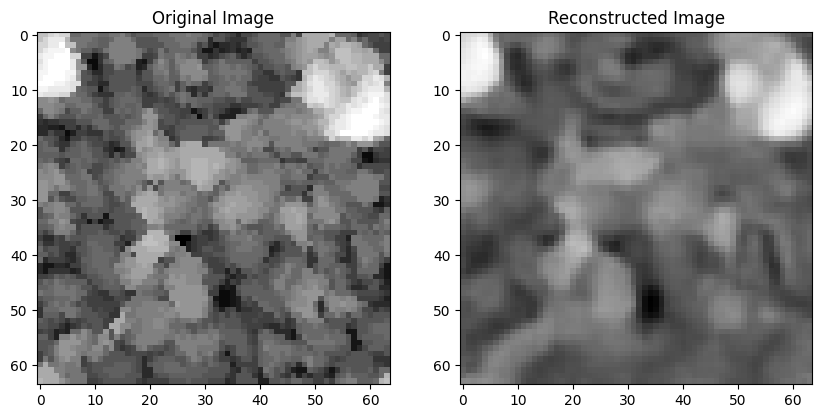

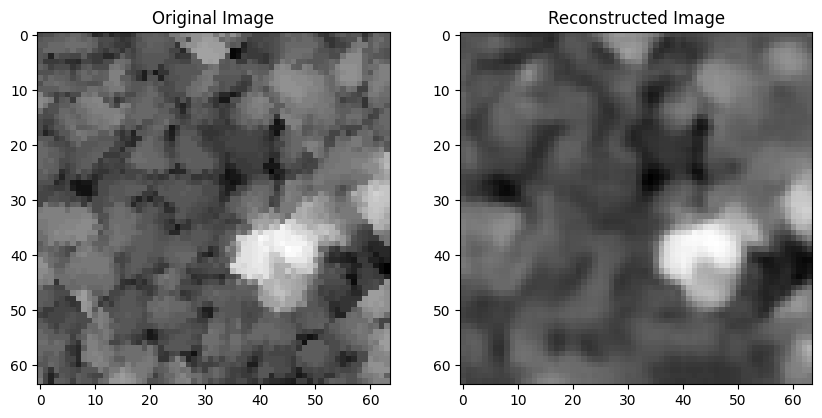

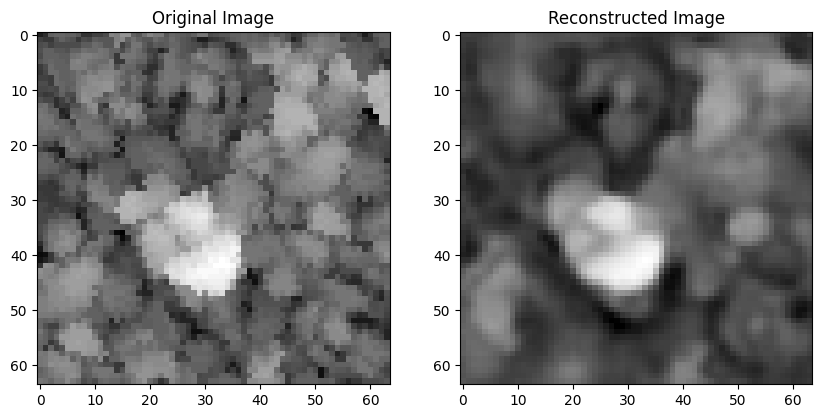

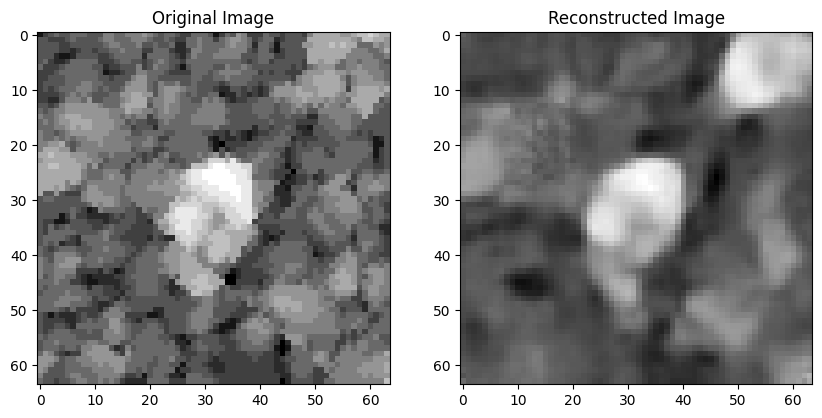

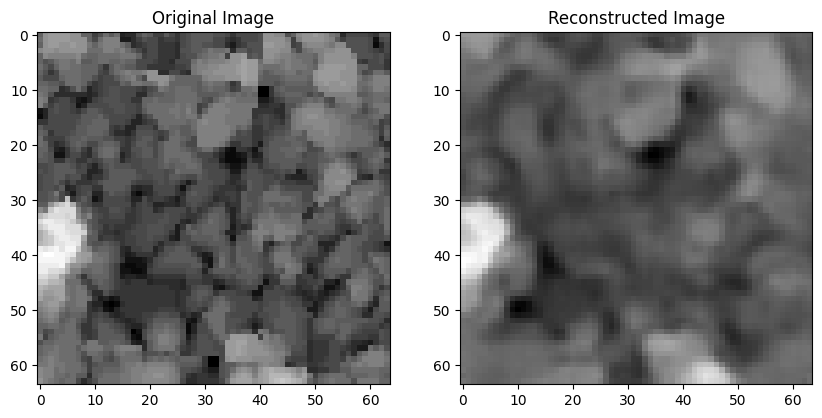

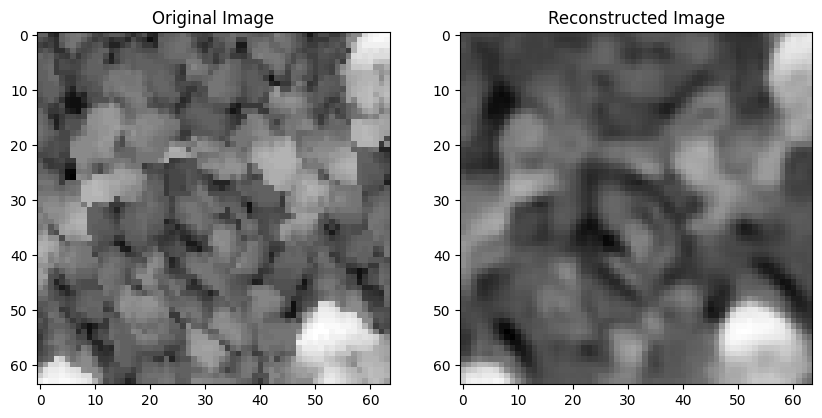

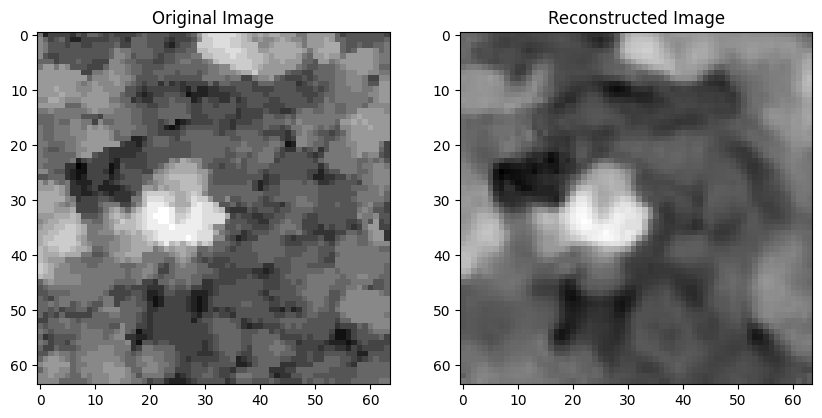

In [9]:
# View the reconstructions of test images
import random
import matplotlib.pyplot as plt

# Function to convert tensor to image for visualization
def to_img(x):
    x = x.clamp(-1, 1)
    x = x.view(-1, 64, 64)
    return x

# Function to display original and reconstructed images
def display_images(original, reconstructed):
    original_img = to_img(original.cpu())
    reconstructed_img = to_img(reconstructed.cpu())
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img[0].numpy(), cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_img[0].numpy(), cmap='gray')
    plt.title('Reconstructed Image')
    plt.show()

# Main loop to process and display images from the test set
def visualize_reconstructions(model, testset, num_images=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load('./SWAE_64.pth'))
    model.eval()
    model.to(device)
    
    # Randomly pick indices for images
    indices = random.sample(range(len(testset)), num_images)
    
    # Loop through the randomly selected indices
    for idx in indices:
        img = testset[idx].unsqueeze(0).to(device)
        
        # Get reconstruction
        with torch.no_grad():
            reconstructed_image, input, latentVector = model(img)
        
        # Display images
        display_images(img, reconstructed_image)

# Assuming 'Testset' is your test dataset
print("Visualizing reconstructions of test images...")
visualize_reconstructions(model, Testset)

In [10]:
model.load_state_dict(torch.load('./SWAE_64.pth'))
model.freeze_encoder()
model.eval()

for name, param in model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

encoder.0.0.weight: requires_grad = False
encoder.0.0.bias: requires_grad = False
encoder.0.1.weight: requires_grad = False
encoder.0.1.bias: requires_grad = False
encoder.1.0.weight: requires_grad = False
encoder.1.0.bias: requires_grad = False
encoder.1.1.weight: requires_grad = False
encoder.1.1.bias: requires_grad = False
encoder.2.0.weight: requires_grad = False
encoder.2.0.bias: requires_grad = False
encoder.2.1.weight: requires_grad = False
encoder.2.1.bias: requires_grad = False
encoder.3.0.weight: requires_grad = False
encoder.3.0.bias: requires_grad = False
encoder.3.1.weight: requires_grad = False
encoder.3.1.bias: requires_grad = False
encoder.4.0.weight: requires_grad = False
encoder.4.0.bias: requires_grad = False
encoder.4.1.weight: requires_grad = False
encoder.4.1.bias: requires_grad = False
fc_z.weight: requires_grad = False
fc_z.bias: requires_grad = False
decoder_input.weight: requires_grad = True
decoder_input.bias: requires_grad = True
decoder.0.0.weight: requires